In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import rotate
from matplotlib.colors import LinearSegmentedColormap
import dijkstra3d
from matplotlib.patches import Rectangle
import heapq
from matplotlib.transforms import Affine2D
from skimage.morphology import medial_axis
from skimage.morphology import skeletonize, skeletonize_3d

import networkx as nx




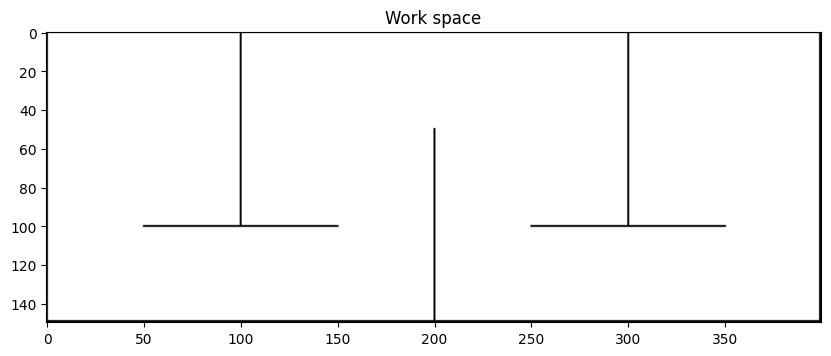

In [2]:

# Robot and space parameters
grid_size = 2

robot_width = 50 // grid_size
robot_height = 50 // grid_size
space_width = 800 // grid_size
space_height = 300 // grid_size

# Configuration space initialization
work_space = np.zeros((space_height, space_width), dtype=int)

# Outer walls [xmin, xmax, ymin, ymax]
outer_wall_top = np.array([[0, space_width, 0, 1]])
outer_wall_bottom = np.array([[0, space_width, space_height-1, space_height]])
outer_wall_left = np.array([[0, 1, 0, space_height]])
outer_wall_right = np.array([[space_width-1, space_width, 0, space_height]])

outer_walls = np.array([outer_wall_top, outer_wall_bottom, outer_wall_left, outer_wall_right])

# Inner walls [xmin, xmax, ymin, ymax]
inner_wall_1 = np.array([[200 // grid_size, 200 // grid_size + 1, 0, 200 // grid_size]])
inner_wall_2 = np.array([[100 // grid_size, 300 // grid_size + 1, 200 // grid_size, 200 // grid_size + 1]])
inner_wall_3 = np.array([[400 // grid_size , 400 // grid_size + 1, 100 // grid_size, 300 // grid_size + 1]])
inner_wall_4 = np.array([[600 // grid_size, 600 // grid_size + 1, 0, 200 // grid_size]])
inner_wall_5 = np.array([[500 // grid_size, 700 // grid_size + 1, 200 // grid_size, 200 // grid_size + 1]])

inner_walls = np.array([inner_wall_1, inner_wall_2, inner_wall_3, inner_wall_4, inner_wall_5])


for wall in outer_walls:
    work_space[wall[0, 2]:wall[0, 3], wall[0, 0]:wall[0, 1]] = 1

for wall in inner_walls:
    work_space[wall[0, 2]:wall[0, 3], wall[0, 0]:wall[0, 1]] = 1


cmap = plt.cm.gray
inverse_gray_cmap = LinearSegmentedColormap.from_list('inverse_gray', cmap(np.linspace(1, 0, cmap.N)))
plt.figure(figsize=(10, 10))
plt.imshow(work_space, cmap=inverse_gray_cmap)
plt.title('Work space')
plt.show()

In [3]:
def calculate_distance_from_path(path):
    path = np.array(path)
    if path.shape[1] == 3:
        path = path[:, 0:2]
    
    distance = 0
    for i in range(len(path)-1):
        distance += np.sqrt((path[i+1, 0]**2 - path[i, 0])**2 + (path[i+1, 1]**2 - path[i, 1])**2)

    return distance / (150*400)

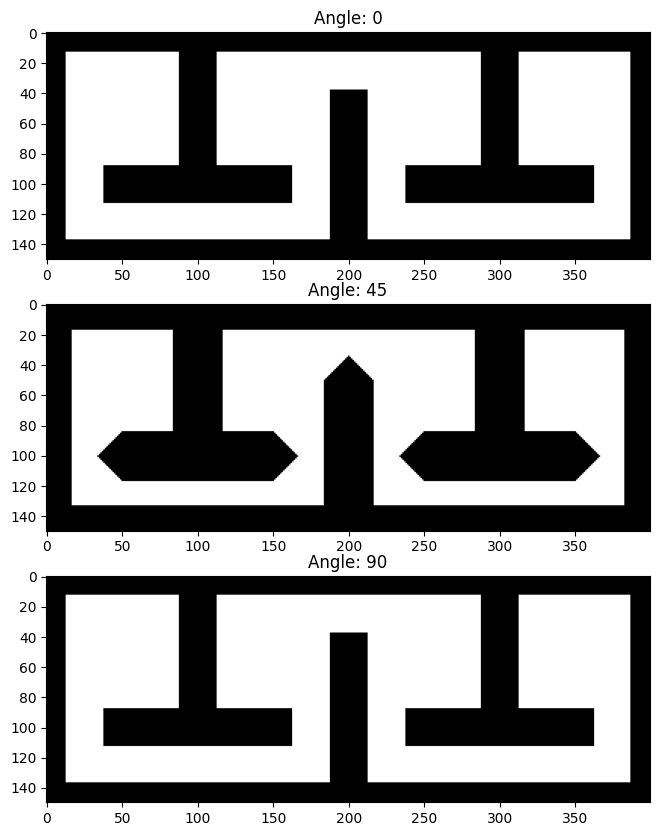

In [4]:
robot_mask = np.ones((robot_height, robot_width), dtype=int)

angles = np.arange(0, 180, 5)

config_space = np.zeros((space_height, space_width, len(angles)), dtype=int)

idx_for_plot = []
for idx, angle in enumerate(angles):
    rotated_robot_mask = rotate(robot_mask, angle, order=0, reshape=True)
    rotated_robot_mask[rotated_robot_mask > 0.5] = 1
    convolved_result = convolve2d(work_space, rotated_robot_mask, mode='same', boundary='fill', fillvalue=0)
    convolved_result[convolved_result != 0] = 1
    config_space[:, :, idx] = convolved_result
    
    if angle == 0 or angle == 45 or angle == 90:
        idx_for_plot.append(idx)

cmap = plt.cm.gray
inverse_gray_cmap = LinearSegmentedColormap.from_list('inverse_gray', cmap(np.linspace(1, 0, cmap.N)))
plt.figure(figsize=(10, 10))
for idx in idx_for_plot:
    plt.subplot(3, 1, idx_for_plot.index(idx) + 1)
    plt.imshow(config_space[:, :, idx], cmap=inverse_gray_cmap)
    plt.title('Angle: {}'.format(angles[idx]))
plt.show()


In [5]:
source = (50 // grid_size, 50 // grid_size, 0)
target = (50 // grid_size, 750 // grid_size, 0)




In [6]:
def astar_3d(field, start, target):
    directions = [(0, 0, 1), (0, 0, -1), (0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0),
                  (1, 1, 0), (1, -1, 0), (-1, 1, 0), (-1, -1, 0), (1, 0, 1), (1, 0, -1),
                  (-1, 0, 1), (-1, 0, -1), (0, 1, 1), (0, 1, -1), (0, -1, 1), (0, -1, -1),
                  (1, 1, 1), (1, 1, -1), (-1, 1, 1), (-1, 1, -1), (1, -1, 1), (1, -1, -1),
                  (-1, -1, 1), (-1, -1, -1)]

    def is_valid_move(x, y, z):
        return 0 <= x < field.shape[0] and 0 <= y < field.shape[1] and 0 <= z < field.shape[2] and field[x, y, z] == 0

    def neighbors(x, y, z):
        valid_neighbors = []
        for dx, dy, dz in directions:
            new_x, new_y, new_z = x + dx, y + dy, z + dz
            if is_valid_move(new_x, new_y, new_z):
                valid_neighbors.append((new_x, new_y, new_z))
        return valid_neighbors

    def heuristic(a, b):
        return np.linalg.norm(np.array(a) - np.array(b))

    heap = [(0, start, [])]
    visited = set()

    while heap:
        cost, current, path = heapq.heappop(heap)

        if current == target:
            return path + [current], visited

        if current in visited:
            continue

        visited.add(current)

        for neighbor in neighbors(*current):
            new_cost = cost + 1
            priority = new_cost + heuristic(target, neighbor)
            heapq.heappush(heap, (priority, neighbor, path + [current]))

    return None

source = (50 // grid_size, 50 // grid_size, 0)
target = (50 // grid_size, 750 // grid_size, 0)

path, visited = astar_3d(config_space, source, target)

Path length: 553
Path length: 552


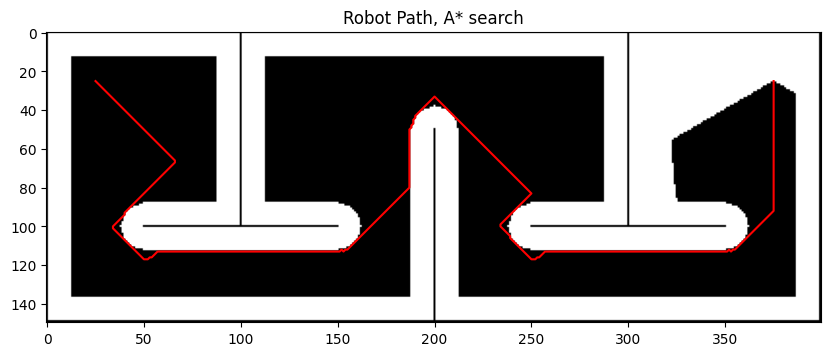

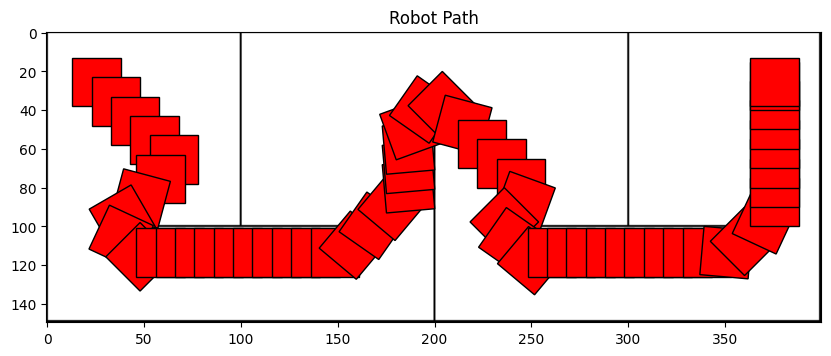

In [ ]:

print('Path length: {}'.format(len(path)))

# Calculate the path length by only considering the x and y coordinates, one step is 1 unit
path_length = 0
for i in range(len(path)-1):
    if path[i][0] == path[i+1][0] and path[i][1] == path[i+1][1]:
        continue
    path_length += 1
print('Path length: {}'.format(path_length))

def get_angle(z):
    angles = np.arange(0, 180, 5)
    return angles[z]

def plot_robot_on_path(work_space, path, robot_size):
    fig, ax = plt.subplots(figsize=(10, 10))    
    cmap = plt.cm.gray
    inverse_gray_cmap = LinearSegmentedColormap.from_list('inverse_gray', cmap(np.linspace(1, 0, cmap.N)))
    ax.imshow(work_space, cmap=inverse_gray_cmap)

    for idx, point in enumerate(path):
        if idx % 10 == 0 or idx == len(path) - 1:
            x, y, z = point
            angle = get_angle(z)
            rect = Rectangle((y - robot_size[1] // 2, x - robot_size[0] // 2), robot_size[1], robot_size[0], angle=0, color='r')
            rect.set_transform(Affine2D().rotate_deg_around(y, x, angle) + ax.transData)
            rect.set_edgecolor('black')
            ax.add_patch(rect)
        

    plt.title('Robot Path')
    plt.show()

path2d = np.array([(x, y) for x, y, _ in path])
visited2d = np.array([(x, y) for x, y, _ in visited])
visited_mask = np.zeros_like(work_space, dtype=bool)
visited_mask[visited2d[:, 0], visited2d[:, 1]] = True

work_space_with_visited = np.copy(work_space)

work_space_with_visited[visited_mask] = 1 


fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.gray
inverse_gray_cmap = LinearSegmentedColormap.from_list('inverse_gray', cmap(np.linspace(1, 0, cmap.N)))
ax.imshow(work_space_with_visited , cmap=inverse_gray_cmap)
ax.plot(path2d[:, 1], path2d[:, 0], 'r')
plt.title('Robot Path, A* search')
plt.show()

plot_robot_on_path(work_space.copy(), path, robot_size=(robot_height, robot_width))

In [ ]:
test_cspace = config_space


binary_image = test_cspace.copy() 
binary_image[binary_image == 0] = 2
binary_image[binary_image == 1] = 0
binary_image[binary_image == 2] = 1


skeleton = skeletonize_3d(binary_image)
skeleton = skeleton.astype(np.uint32)

skeleton[skeleton == 1] = 2
skeleton[skeleton == 0] = 1
skeleton[skeleton == 2] = 0


def get_closest_point(skeleton, source):
    skeleton_points = np.array(np.where(skeleton == 0)).T
    skeleton_points = skeleton_points.astype(np.float32)
    source = np.array(source)
    source = source.astype(np.float32)
    distances = np.linalg.norm(skeleton_points - source, axis=1)
    closest_point = skeleton_points[np.argmin(distances)]
    closest_point = closest_point.astype(np.uint32)
    return closest_point

source = (50 // grid_size, 50 // grid_size, 0)
target = (50 // grid_size, 750 // grid_size, 0)

closest_point_source = get_closest_point(skeleton, source)
closest_point_target = get_closest_point(skeleton, target)

closest_point_source = tuple(closest_point_source)
closest_point_target = tuple(closest_point_target)

empty_field = np.zeros_like(skeleton)

path_source_skeleton = astar_3d(empty_field, source, closest_point_source)
path_target_skeleton = astar_3d(empty_field, target, closest_point_target)

for point in path_source_skeleton:
    skeleton[point] = 0

for point in path_target_skeleton:
    skeleton[point] = 0


c:\Users\haako\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\util\dtype.py:549: UserWarning: Downcasting int32 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


In [ ]:
source = (50 // grid_size, 50 // grid_size, 0)
target = (50 // grid_size, 750 // grid_size, 0)

boolean_field = skeleton.astype(bool)

path_safe = dijkstra3d.binary_dijkstra(boolean_field, source, target, background_color=1)


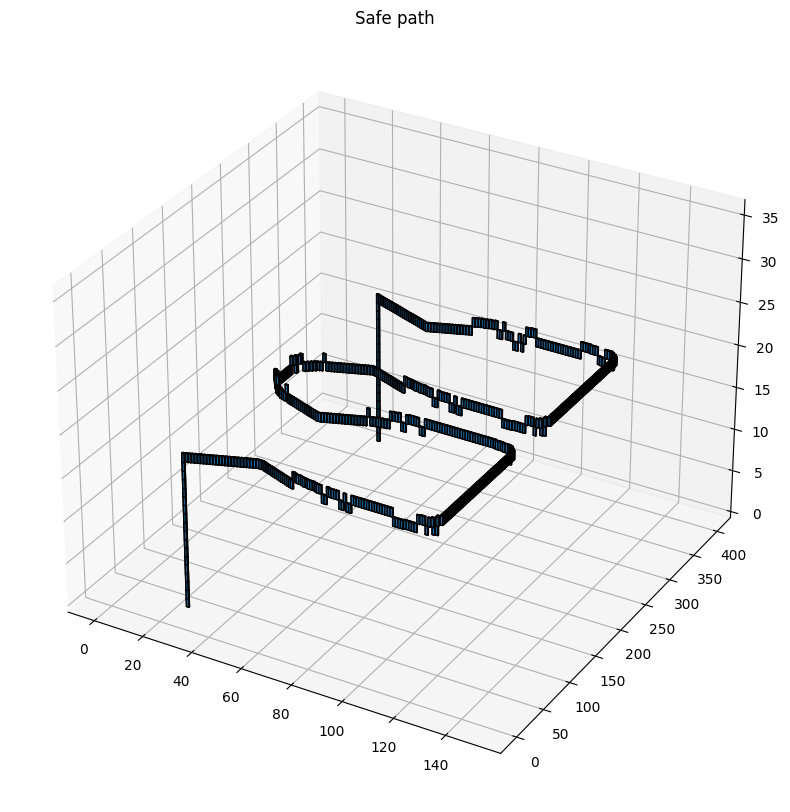

In [ ]:
skeleton_test = skeleton.copy()
skeleton_test[skeleton_test == 0] = 2
skeleton_test[skeleton_test == 1] = 0
skeleton_test[skeleton_test == 2] = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(skeleton_test, edgecolor='k')
plt.title('Safe path')
plt.show()

Path length: 760
Path length: 727


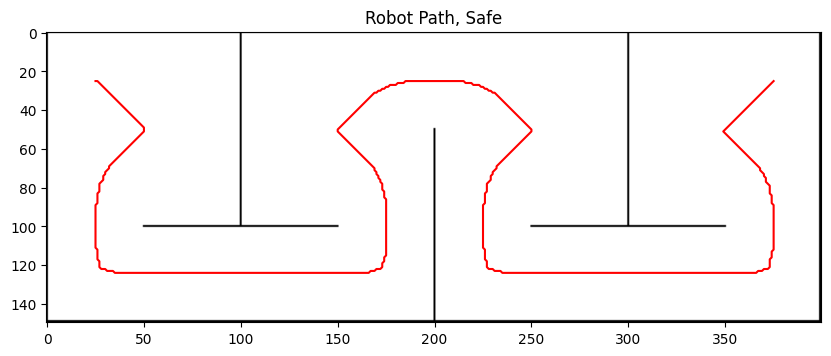

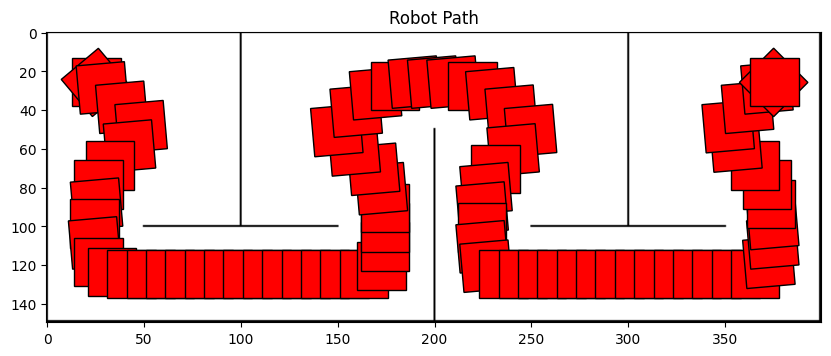

In [ ]:

print('Path length: {}'.format(len(path_safe)))
path_length = 0
for i in range(len(path_safe)-1):
    if path_safe[i][0] == path_safe[i+1][0] and path_safe[i][1] == path_safe[i+1][1]:
        continue
    path_length += 1
print('Path length: {}'.format(path_length))

path2d = np.array([(x, y) for x, y, _ in path_safe])
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.gray
inverse_gray_cmap = LinearSegmentedColormap.from_list('inverse_gray', cmap(np.linspace(1, 0, cmap.N)))
ax.imshow(work_space, cmap=inverse_gray_cmap)
ax.plot(path2d[:, 1], path2d[:, 0], 'r')
plt.title('Robot Path, Safe')
plt.show()

plot_robot_on_path(work_space.copy(), path_safe, robot_size=(robot_height, robot_width))

In [ ]:
def connect_lines_in_path(field, path):
    connected_path = []

    def draw_line(x0, y0, x1, y1):
        line_points = []
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        sx = 1 if x0 < x1 else -1
        sy = 1 if y0 < y1 else -1
        err = dx - dy

        while x0 != x1 or y0 != y1:
            line_points.append((x0, y0))
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x0 += sx
            if e2 < dx:
                err += dx
                y0 += sy

        return line_points
    
    for i in range(len(path) - 1):
        x0, y0 = path[i]
        x1, y1 = path[i + 1]
        connected_path.extend(draw_line(x0, y0, x1, y1))

    x_last, y_last = path[-1]
    connected_path.append((x_last, y_last))

    return connected_path

In [ ]:

def prm_2d(n_nodes, field, source, target):

    sampled_points = []
    sampled_points.append(source)
    sampled_points.append(target)
    while len(sampled_points) < n_nodes:
        x = np.random.randint(0, field.shape[0])
        y = np.random.randint(0, field.shape[1])
        if field[x, y] == 0:
            sampled_points.append((x, y))
    
    
    def is_collision_free_line(field, point1, point2):
        line = np.linspace(point1, point2, 100)
        line = line.astype(np.int32)
        for point in line:
            x, y = point
            if field[x, y] == 1:
                return False
        return True

    G = nx.Graph()
    for point in sampled_points:
        G.add_node(point)

    for point in sampled_points:
        for other_point in sampled_points:
            if point != other_point:
                if not G.has_edge(point, other_point):
                    if is_collision_free_line(field, point, other_point):
                        G.add_edge(point, other_point, weight=np.linalg.norm(np.array(point) - np.array(other_point)))
    
    path = nx.dijkstra_path(G, source, target)
    return G, path


def plot_prm_graph(G, path, field, n_nodes):
    node_coordinates = {}
    for node in G.nodes():
        x, y = node
        new_coordinates = (y, x)
        node_coordinates[node] = new_coordinates
    nx.draw(G, node_coordinates, with_labels=False, node_size=10, node_color='skyblue')

    nx.draw_networkx_edges(G, node_coordinates, edge_color='b', alpha=0.1, width=1)

    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, node_coordinates, edgelist=path_edges, edge_color='r', width=2)

    cmap = plt.cm.gray
    inverse_gray_cmap = LinearSegmentedColormap.from_list('inverse_gray', cmap(np.linspace(1, 0, cmap.N)))
    plt.imshow(field, cmap=inverse_gray_cmap, origin='upper')
    plt.title("PRM Graph with Best Path for {} Nodes".format(n_nodes))
    plt.show()



In [ ]:
def calculate_distance_from_path2d(path):
    distance = 0
    for i in range(path.shape[0]-1):
        distance += np.sqrt((path[i+1, 0]**2 - path[i, 0])**2 + (path[i+1, 1]**2 - path[i, 1])**2)

    return distance / len(path)

Path Length 50: 732


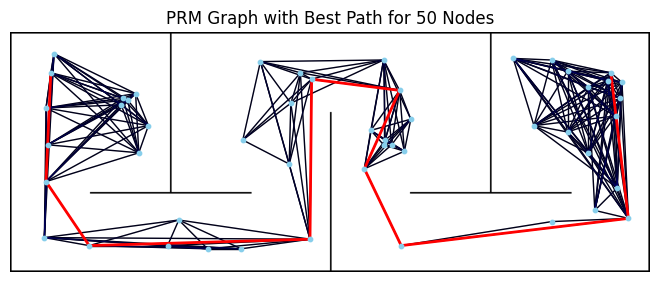

Path Length 100: 695


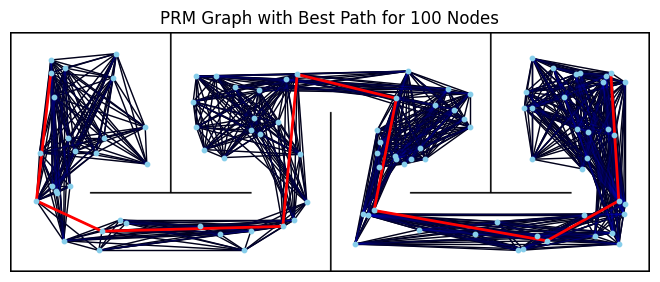

Path Length 500: 637


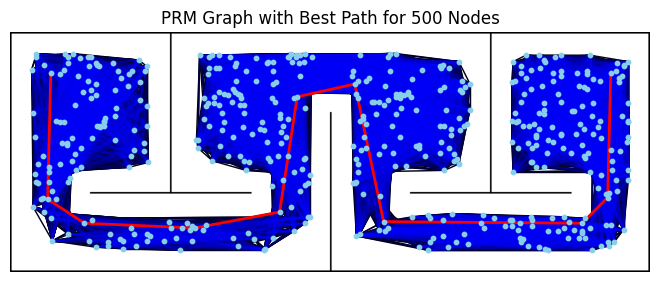

In [ ]:
source2d = (50 // grid_size, 50 // grid_size)
target2d = (50 // grid_size, 750 // grid_size)
    

prm_graph, path_prm = prm_2d(50, config_space[:, :, 0], source2d, target2d)
connected_path = connect_lines_in_path(config_space, path_prm)
print('Path Length 50: {}'.format(len(connected_path)))
plot_prm_graph(prm_graph, path_prm, work_space, 50)

prm_graph, path_prm = prm_2d(100, config_space[:, :, 0], source2d, target2d)
connected_path = connect_lines_in_path(config_space, path_prm)
print('Path Length 100: {}'.format(len(connected_path)))
plot_prm_graph(prm_graph, path_prm, work_space, 100)

prm_graph, path_prm = prm_2d(500, config_space[:, :, 0], source2d, target2d)
connected_path = connect_lines_in_path(config_space, path_prm)
print('Path Length 500: {}'.format(len(connected_path)))
plot_prm_graph(prm_graph, path_prm, work_space, 500)




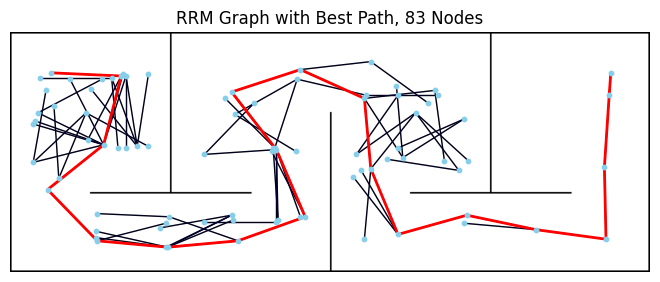

In [ ]:
def rrm_2d(field, source, target, deltaq=10, max_iter=2000, max_nodes=1000):
    def is_collision_free_line(field, point1, point2):
        line = np.linspace(point1, point2, 100)
        line = line.astype(np.int32)
        for point in line:
            x, y = point
            if field[x, y] == 1:
                return False
        return True
    
    def get_random_point(field):
        x = np.random.randint(0, field.shape[0])
        y = np.random.randint(0, field.shape[1])
        if field[x, y] == 0:
            return (x, y)
        else:
            return get_random_point(field)
        

    G = nx.Graph()
    G.add_node(source)


    for i in range(max_iter):
        if len(G.nodes()) >= max_nodes:
            break

        q_rand = get_random_point(field)
        if q_rand in G.nodes():
            continue

        q_near = None
        min_dist = np.inf

        for node in G.nodes():
            dist = np.linalg.norm(np.array(node) - np.array(q_rand))
            if dist < min_dist:
                min_dist = dist
                q_near = node

        direction = (np.array(q_rand) - np.array(q_near)) / np.linalg.norm(np.array(q_rand) - np.array(q_near))
        
        q_new = q_near + deltaq * direction
        q_new = q_new.astype(np.int32)

        if np.linalg.norm(np.array(q_new)-np.array(target)) < deltaq:
            G.add_node(tuple(q_new))
            G.add_node(target)
            G.add_edge(q_near, tuple(q_new), weight=np.linalg.norm(np.array(q_near) - np.array(q_new)))
            G.add_edge(tuple(q_new), target, weight=np.linalg.norm(np.array(q_new) - np.array(target)))
            break
       
        if is_collision_free_line(field, q_near, q_new):
            G.add_node(tuple(q_new))
            G.add_edge(q_near, tuple(q_new), weight=np.linalg.norm(np.array(q_near) - np.array(q_new)))
            
    try:
        path = nx.astar_path(G, source, target)
    except:
        path = []

    return G, path


def plot_rrt_graph(G, path, field):
    node_coordinates = {}
    for node in G.nodes():
        x, y = node
        new_coordinates = (y, x)
        node_coordinates[node] = new_coordinates
    nx.draw(G, node_coordinates, with_labels=False, node_size=10, node_color='skyblue')
    number_of_nodes = len(G.nodes())

    nx.draw_networkx_edges(G, node_coordinates, edge_color='b', alpha=0.1, width=1)

    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, node_coordinates, edgelist=path_edges, edge_color='r', width=2)

    cmap = plt.cm.gray
    inverse_gray_cmap = LinearSegmentedColormap.from_list('inverse_gray', cmap(np.linspace(1, 0, cmap.N)))
    plt.imshow(field, cmap=inverse_gray_cmap, origin='upper')
    plt.title("RRM Graph with Best Path, {} Nodes".format(number_of_nodes))
    plt.show()


rrm_graph, path_rrt = rrm_2d(config_space[:, :, 0], source2d, target2d, deltaq=45, max_iter=2000, max_nodes=100)
# print(path_prm)
# conencted_path_rrt = connect_lines_in_path(config_space, path_rrt)
# print('Path Length RRM: {}'.format(len(conencted_path_rrt)))
plot_rrt_graph(rrm_graph, path_rrt, work_space)





In [ ]:
conencted_path_rrt = connect_lines_in_path(config_space, path_rrt)
print('Path Length RRM: {}'.format(len(conencted_path_rrt)))

Path Length RRM: 765
